In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns


pd.set_option('display.max_colwidth', 0)

In [2]:
DOMAIN="clinical"

def replace_quotation(el):
    try:
        return json.loads(el)
    except:
        el = el.replace("\'", '"')
        
def load_csv(csv_path):
    df = pd.read_csv(csv_path).query(f"domain=='{DOMAIN}'").reset_index(drop=True)
    df.loc[:, "medical_entities"] =  df.loc[:, "detect_entities"].apply(lambda x: replace_quotation(x))
    return df

In [3]:
csv_path="../NER/entities/full_intron-train-public-58000-clean_with_entities.csv"
df_train = load_csv(csv_path)

csv_path="../NER/entities/full_intron-dev-public-3231-clean_with_entities.csv"
df_dev = load_csv(csv_path)

csv_path="../NER/entities/full_intron-test-public-6346-clean_with_entities.csv"
df_test = load_csv(csv_path)

print(len(df_train), len(df_dev), len(df_test))

36318 1824 3623


In [4]:
df_test.head(1)

,Unnamed: 0,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,gender,detect_entities,detect_phi,medical_entities
0,0,149716,5ab7b49ad1cab6392a764a69578dc822,twi,26-40,GH,Proteins break down to release amino acids which are used as fuel for hepatic gluconeogenesis to maintain the glucose needs of the brain.,136,3a21d00eec39a31f089b9b4f0f8afa21,/AfriSpeech-100/test/e696aff8-ce05-4c8e-a3b3-5634f3da50b9/3b55a5d83ae194039127818b59e5b78a.wav,10.776984,african,clinical,test,Female,"{\n ""Entities"": [\n {\n ""Id"": 1,\n ""BeginOffset"": 131,\n ""EndOffset"": 136,\n ""Score"": 0.9999834299087524,\n ""Text"": ""brain"",\n ""Category"": ""ANATOMY"",\n ""Type"": ""SYSTEM_ORGAN_SITE"",\n ""Traits"": []\n }\n ],\n ""UnmappedAttributes"": [],\n ""ModelVersion"": ""2.3.0""\n}\n","{\n ""Entities"": [],\n ""ModelVersion"": ""1.1.0""\n}\n","{'Entities': [{'Id': 1, 'BeginOffset': 131, 'EndOffset': 136, 'Score': 0.9999834299087524, 'Text': 'brain', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}"


In [5]:
def get_entities_values(df, attribute="Score"):
    values = []
    for i in range(len(df)):
        entities = df["medical_entities"][i]
        if entities is not None:
            entities = entities["Entities"]
            for j in range(len(entities)):
                values.append(entities[j][attribute])
    return values

In [6]:
categories = list(set(get_entities_values(df_test, attribute="Category")))

# make sure the entities categories are the same for train and test
assert list(set(get_entities_values(df_train, attribute="Category"))) == categories
categories

['TEST_TREATMENT_PROCEDURE',
 'ANATOMY',
 'TIME_EXPRESSION',
 'PROTECTED_HEALTH_INFORMATION',
 'MEDICATION',
 'MEDICAL_CONDITION',
 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL']

We're only focusing on four categories for this project
- MEDICATION
- MEDICAL_CONDITION
- ANATOMY
- PROTECTED_HEALTH_INFORMATION

In [7]:
VALID_CATEGORIES = ["MEDICATION", "MEDICAL_CONDITION", "ANATOMY", "PROTECTED_HEALTH_INFORMATION"]

,scores_train
count,97349.000000
mean,0.851239
std,0.186356
min,0.052329
25%,0.730901
50%,0.950973
75%,0.997645
max,1.000000


,scores_test
count,9146.000000
mean,0.852707
std,0.186175
min,0.098740
25%,0.729393
50%,0.954385
75%,0.997776
max,1.000000


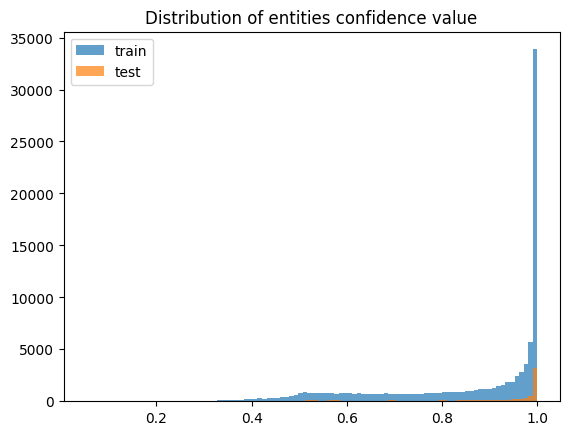

In [8]:
scores_train =  get_entities_values(df_train, attribute="Score")
display(pd.DataFrame(scores_train, columns=["scores_train"]).describe())

scores_test =  get_entities_values(df_test, attribute="Score")
display(pd.DataFrame(scores_test, columns=["scores_test"]).describe())

_ = plt.hist(scores_train, bins=100, label="train", alpha=0.7)
_ = plt.hist(scores_test, bins=100, label="test", alpha=0.7)

plt.legend()
_ = plt.title("Distribution of entities confidence value")

In [9]:
# Are the scores calibrated?
def scores_per_category(df):
    medical_entities = df.medical_entities
    scores_dict = {}
    
    for el in medical_entities:
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                text = entity["Text"]
                category = entity["Category"]
                score = entity["Score"]
                if scores_dict.get(category) is None:
                    scores_dict[category] = [score]
                else:
                    scores_dict[category].append(score)
    return scores_dict

scores_per_cat = scores_per_category(df_train)
for k in scores_per_cat.keys():
    print(f"Scores for {k}")
    print(f"Min value: {round(min(scores_per_cat[k]), 3)}", f"Max value: {round(max(scores_per_cat[k]), 3)}")
    

Scores for MEDICAL_CONDITION
Min value: 0.265 Max value: 1.0
Scores for ANATOMY
Min value: 0.25 Max value: 1.0
Scores for TIME_EXPRESSION
Min value: 0.312 Max value: 1.0
Scores for TEST_TREATMENT_PROCEDURE
Min value: 0.156 Max value: 1.0
Scores for BEHAVIORAL_ENVIRONMENTAL_SOCIAL
Min value: 0.253 Max value: 1.0
Scores for PROTECTED_HEALTH_INFORMATION
Min value: 0.052 Max value: 1.0
Scores for MEDICATION
Min value: 0.207 Max value: 1.0


In [10]:
def get_transcript_per_category(df, category, min_range, max_range):
    medical_entities = df.medical_entities
    idxs = []
    texts = []
    scores = []
    
    for idx, el in enumerate(medical_entities):
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                score = entity["Score"]
                if entity["Category"] == category and  (min_range <= score and max_range >= score):
                    idxs.append(idx)
                    texts.append(entity["Text"])
                    scores.append(score)
    df = df.iloc[idxs]
    df.loc[:, "category"] = [category]*len(df)
    df.loc[:, "text"] = texts
    df.loc[:, "score"] = scores
    return df

In [11]:
def transcript_per_category_range(df, n=1, min_range=0, max_range=1, random_state=42):
    out_df = []
    for category in VALID_CATEGORIES:
        out = get_transcript_per_category(df, category=category, min_range=min_range, max_range=max_range)
        if len(out) > n:
            out_df.append(out[["transcript", "category", "text", "score"]].sample(n, random_state=random_state))
        else:
            out_df.append(out[["transcript", "category", "text", "score"]].head(n))

    out_df = pd.concat(out_df).sort_values(["category", "score"], ascending=True)
    return out_df

In [12]:
min_range=0
max_range=0.3
random_state=42
n=5

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "category"] = [category]*len(df)
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "text"] = texts
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,transcript,category,text,score
31164,NNP Physical ExamPE: pink active infant supine in crib AFOF sutures apposed breath sounds clear/equal with easy WOB RRr without murmur normal pulses and perfusion abd sfot non distended + bowel sounds active with good tone.,ANATOMY,NNP,0.250345
25012,"Laceration of muscle, fascia and tendon of other parts of biceps, left. INJECTABLE, INJECTION BREVIBLOC, ESMOLOL HYDROCHLORIDE, 20MG/ML. Other physeal fracture of upper end of humerus, right arm, subsequent",ANATOMY,end,0.274194
5281,Note that each posterior root divides into several rootlets that enter the spinal cord.,ANATOMY,root,0.287205
27507,"Nondisplaced spiral fracture of shaft of radius, left arm, subsequent. TABLET, ORAL LOSARTAN POTASSIUM, LOSARTAN POTASSIUM, 100MG. Other mechanical complication of intraperitoneal dialysis catheter, se",ANATOMY,shaft of radius,0.294018
34001,"Thyrotoxicosis factitia without thyrotoxic crisis or storm. POWDER, INHALATION ANORO ELLIPTA, UMECLIDINIUM BROMIDE; VILANTEROL TRIFENATATE, EQ 0.0625MG BASE/INH;EQ 0.025MG BASE/INH. Other physeal fracture of upper end of radius, unspecified arm, subseq",ANATOMY,end of radius,0.297595
6928,"It is very important to prevent fluid from accumulating in the alveoli, because gases diffuse too slowly through liquid to sufficiently aerate the blood.",MEDICAL_CONDITION,fluid,0.270873
5091,Cryptorchidism is unilateral in 80 cases and bilateral in the rest.,MEDICAL_CONDITION,Cryptorchidism,0.276265
34910,Such sessions are imperative for improving outcomes.,MEDICAL_CONDITION,sessions are imperative,0.281227
20781,"Laceration without foreign body of unspecified finger with damage to n. INJECTABLE, INJECTION TOPOTECAN HYDROCHLORIDE, TOPOTECAN HYDROCHLORIDE, EQ 4MG BASE/VIAL. Barton's fracture of unspecified radius, initial encounter for open fr",MEDICAL_CONDITION,Barton's fracture,0.293314
34385,Antibacterial chemotherapy is necessary in diffuse-type chronic mucocutaneous candidosis CMCC and endocrine replacement is essential in endocrine candidosis.,MEDICAL_CONDITION,mucocutaneous candidosis,0.297219


In [13]:
min_range=0.4
max_range=0.6
random_state=42
n=5

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "category"] = [category]*len(df)
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "text"] = texts
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,transcript,category,text,score
35665,"External constriction of left ring finger, initial encounter. TABLET, EXTENDED RELEASE, ORAL INVEGA, PALIPERIDONE, 9MG. Anterior cord syndrome at C6 level of cervical spinal cord, subsequent",ANATOMY,C6,0.508565
13735,"T4 ,T3 , and iodine are stored in the follicular colloid.",ANATOMY,T4,0.525746
26469,"Contusion of thorax, unspecified, subsequent encounter. TABLET, ORAL GLYBURIDE (MICRONIZED), GLYBURIDE, 1.5MG. Drowning and submersion after fall into bathtub, undetermined intent,",ANATOMY,thorax,0.541585
9085,Thick skin has sweat glands but no hair follicles or sebaceous oil glands.,ANATOMY,glands,0.557698
34602,"The lamina dura is a layer of compact bone continuous, at the mouths of the sockets, with the cortical bone of the jaw.",ANATOMY,cortical bone of the jaw,0.572927
20785,"Nondisplaced fracture of anterior process of right calcaneus, initial. INJECTABLE, INJECTION NORCURON, VECURONIUM BROMIDE, 10MG/VIAL . ABO incompatibility reaction due to transfusion of blood or blood prod",MEDICAL_CONDITION,reaction,0.412826
19204,"Nondisplaced trimalleolar fracture of unspecified lower leg, subsequen. SOLUTION, TOPICAL CALCIPOTRIENE, CALCIPOTRIENE, 0.005%. Other fracture of left femur, subsequent encounter for closed fracture",MEDICAL_CONDITION,closed fracture,0.418893
7768,The Omethyl substitutionof erythromycin that results in clarithromycin also confers acid stability and better absorption with food.,MEDICAL_CONDITION,acid stability,0.473204
14960,"A variant of chronic pancreatitis is a non-obstructive, diffusely infiltrative disease associated with fibrosis, a mononuclear cell lymphocyte, plasma cell, or eosinophil infiltrate, and an increased titer of one or more auto-antibodies.",MEDICAL_CONDITION,chronic pancreatitis,0.506214
19812,"Grossly, abscesses may be of variable size from a few millimeters to large cavities, 5 to 6cm in diameter.",MEDICAL_CONDITION,variable size,0.528618


In [14]:
min_range=0.8
max_range=1.0
random_state=42
n=5

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "category"] = [category]*len(df)
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "text"] = texts
/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/2591550258.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,transcript,category,text,score
34748,Successful PTCA and stenting of OM1 with a 3.0 x 18 mm CypherDES.,ANATOMY,OM1,0.996957
12540,"The patient had a CT scan, which revealed a mass in the gallbladder neck, but no biliary dilatation .",ANATOMY,gallbladder neck,0.997106
26073,"Other secondary gout, left shoulder. TABLET, DELAYED RELEASE, ORAL DICLOFENAC SODIUM, DICLOFENAC SODIUM, 50MG. Nondisplaced dome fracture of right talus, subsequent encounter for fr",ANATOMY,talus,0.999884
34789,REMAINS A/A/O AND HAS C/O CHRONIC BACK PAIN TWICE.,ANATOMY,BACK,0.999975
16455,Blood returning from the upper body enters the right atrium via the can between the superior vena cava and the right atrial appendage 698 results And Complications Of Surgical ASD Closure.,ANATOMY,atrium,0.999995
20150,No systemic adverse effects of ribavirin have been reported following administration by aerosol or nebulizer.,MEDICAL_CONDITION,systemic adverse effects of ribavirin,0.847955
3010,Severe 4+ TR.Eccentric TR jet.,MEDICAL_CONDITION,TR,0.916258
32776,"Neurocardiogenic syncope, cardiac arrhythmia, or an obstructive cardiomyopathy can cause recurrent episodes of loss of consciousness.",MEDICAL_CONDITION,syncope,0.956991
29587,She was seen three times in the last week to Hospital Embahfoh Hospital for these symptoms but only on the most recent presentation was she admitted.,MEDICAL_CONDITION,symptoms,0.982209
12300,"In the investigation of thrombotic disorders, a personal or family history of blood clots in the legs or lungs, early-onset stroke, or heart attack suggests a hereditary predisposition to thrombosis.",MEDICAL_CONDITION,stroke,0.997578


In [15]:
# TO DO, check entities with scores <= 0.67. Are these wrong?

In [16]:
SCORE_THRESHOLD=0.0

In [17]:
def concat_entities(el):
    if el is not None:
        entities = el["Entities"]
        texts = []
        for entity in entities:
            text = entity["Text"]
            category = entity["Category"]
            score = entity["Score"]
            if category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
                texts.append(text)
        return "".join(texts)

In [18]:
df_test["cat_entities"] = df_test.medical_entities.apply(lambda x: concat_entities(x))
df_train["cat_entities"] = df_train.medical_entities.apply(lambda x: concat_entities(x))
df_dev["cat_entities"] = df_dev.medical_entities.apply(lambda x: concat_entities(x))

df_test[["domain", "transcript", "medical_entities", "cat_entities"]]

,domain,transcript,medical_entities,cat_entities
0,clinical,Proteins break down to release amino acids which are used as fuel for hepatic gluconeogenesis to maintain the glucose needs of the brain.,"{'Entities': [{'Id': 1, 'BeginOffset': 131, 'EndOffset': 136, 'Score': 0.9999834299087524, 'Text': 'brain', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",brain
1,clinical,To grant such a patent license to a party means to make such an agreement or commitment not to enforce a patent against the party.,"{'Entities': [{'Id': 1, 'BeginOffset': 3, 'EndOffset': 8, 'Score': 0.5067760348320007, 'Text': 'grant', 'Category': 'PROTECTED_HEALTH_INFORMATION', 'Type': 'NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 105, 'EndOffset': 129, 'Score': 0.700817346572876, 'Text': 'patent against the party', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'SIGN', 'Score': 0.5057979822158813}, {'Name': 'NEGATION', 'Score': 0.4281071722507477}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",grantpatent against the party
2,clinical,Flatus indicates return of peristalsis.,"{'Entities': [{'Id': 1, 'BeginOffset': 27, 'EndOffset': 38, 'Score': 0.8273748755455017, 'Text': 'peristalsis', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'SIGN', 'Score': 0.5107210278511047}, {'Name': 'HYPOTHETICAL', 'Score': 0.7282446622848511}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",peristalsis
3,clinical,"Since the degree of effect produced by a drug is generally a function of the amount administered, we can express this relationship in terms of a dose-response curve.","{'Entities': [], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",
4,clinical,Protection of the host immune mechanism mightincrease the efcacy of other drugs that inhibit viralreplication.\n,"{'Entities': [], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",
...,...,...,...,...
3618,clinical,"Displaced fracture of proximal phalanx of unspecified finger, sequela. TABLET, ORAL LOTENSIN, BENAZEPRIL HYDROCHLORIDE, 40MG. Unspecified injury of muscle and tendon of long extensor muscle of toe","{'Entities': [{'Id': 7, 'BeginOffset': 10, 'EndOffset': 18, 'Score': 0.6676874160766602, 'Text': 'fracture', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [], 'Attributes': [{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.7111473083496094, 'RelationshipScore': 0.9924564361572266, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 1, 'BeginOffset': 22, 'EndOffset': 38, 'Text': 'proximal phalanx', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9998871088027954, 'RelationshipScore': 0.9519075155258179, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 2, 'BeginOffset': 54, 'EndOffset': 60, 'Text': 'finger', 'Category': 'ANATOMY', 'Traits': []}]}, {'Id': 1, 'BeginOffset': 22, 'EndOffset': 38, 'Score': 0.7111473083496094, 'Text': 'proximal phalanx', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 2, 'BeginOffset': 54, 'EndOffset': 60, 'Score': 0.9998871088027954, 'Text': 'finger', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 3, 'BeginOffset': 148, 'EndOffset': 154, 'Score': 0.9999840259552002, 'Text': 'muscle', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 4, 'BeginOffset': 159, 'EndOffset': 165, 'Score': 0.9760462641716003, 'Text': 'tendon', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 5, 'BeginOffset': 169, 'EndOffset': 189, 'Score': 0.821911096572876, 'Text': 'long extensor muscle', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 6, 'BeginOffset': 193, 'EndOffset': 196, 'Score': 0.5494443774223328, 'Text': 'toe', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",fractureproximal phalanxfingermuscletendonlong extensor muscletoe
3619,clinical,Reaso

In [19]:
def count_entities(el):
    if el is not None:
        entities = el["Entities"]
        count_medication = 0
        count_medical_condition = 0
        count_anatomy = 0
        count_phi = 0
        
        for entity in entities:
            text = entity["Text"]
            category = entity["Category"]
            score = entity["Score"]
            
            if category == "MEDICATION" and score >= SCORE_THRESHOLD:
                count_medication += 1
            
            if category == "MEDICAL_CONDITION" and score >= SCORE_THRESHOLD:
                count_medical_condition += 1
            
            if category == "ANATOMY" and score >= SCORE_THRESHOLD:
                count_anatomy += 1
            
            if category == "PROTECTED_HEALTH_INFORMATION" and score >= SCORE_THRESHOLD:
                count_phi += 1       
        return count_medication, count_medical_condition, count_anatomy, count_phi
    else:
        0, 0, 0, 0

In [20]:
def get_entities_count(df):
    df[['MEDICATION', 'MEDICAL_CONDITION', 'ANATOMY', 'PROTECTED_HEALTH_INFORMATION']] = df['medical_entities'].apply(
        lambda x: pd.Series(count_entities(x), dtype=int)
    )
    return df


In [21]:
def plot_entities_distribution(df, subset):
    df_categories = df[VALID_CATEGORIES]
    g = sns.barplot(df_categories)
    _ = plt.xticks(rotation=30) 
    plt.title(f"Distribution of Entities [{subset}]")

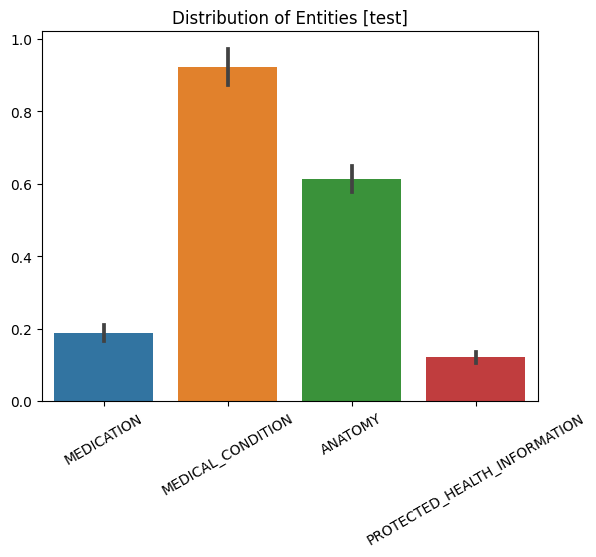

In [22]:
df_test = get_entities_count(df_test)
plot_entities_distribution(df_test, subset="test")

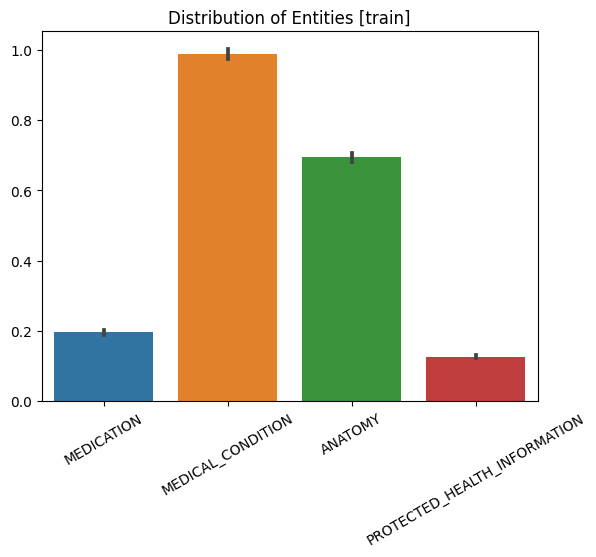

In [23]:
df_train = get_entities_count(df_train)
plot_entities_distribution(df_train, subset="train")

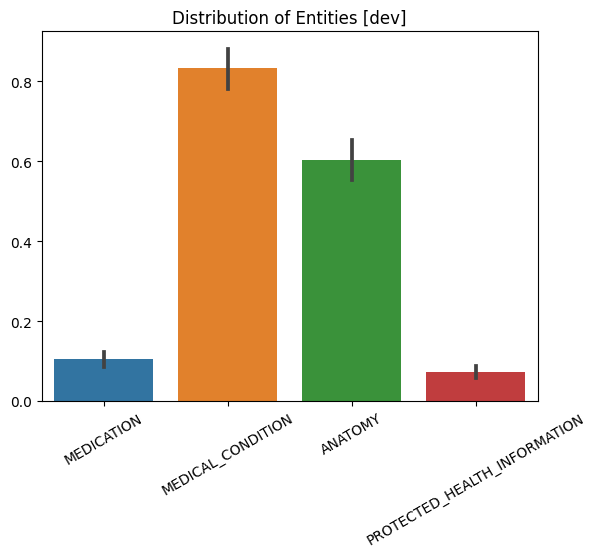

In [24]:
df_dev = get_entities_count(df_dev)
plot_entities_distribution(df_dev, subset="dev")

In [25]:
subset="test"
df = df_test
total_no_entities = df[df["cat_entities"] == ""][["transcript", "medical_entities"]]
print(f"total {subset} = {len(df)},\ntotal {subset} with no entity of interest = {len(total_no_entities)}\nremaining = {len(df)- len(total_no_entities)}")


total test = 3623,
total test with no entity of interest = 1156
remaining = 2467


In [26]:
subset="train"
df = df_train
total_no_entities = df[df["cat_entities"] == ""][["transcript", "medical_entities"]]
print(f"total {subset} = {len(df)},\ntotal {subset} with no entity of interest = {len(total_no_entities)}\nremaining = {len(df)- len(total_no_entities)}")


total train = 36318,
total train with no entity of interest = 10621
remaining = 25697


In [27]:
subset="dev"
df = df_dev
total_no_entities = df[df["cat_entities"] == ""][["transcript", "medical_entities"]]
print(f"total {subset} = {len(df)},\ntotal {subset} with no entity of interest = {len(total_no_entities)}\nremaining = {len(df)- len(total_no_entities)}")


total dev = 1824,
total dev with no entity of interest = 579
remaining = 1245


In [28]:
df_test = df_test[df_test["cat_entities"] != ""]
df_train = df_train[df_train["cat_entities"] != ""]
df_dev = df_dev[df_dev["cat_entities"] != ""]

In [29]:
# df_dev[["domain", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES]].head()

In [30]:
# All the pretrained model results are stored here
pretrained_df = pd.read_csv("../results/normalized/intron-open-test-all_models.csv")
print(pretrained_df.shape)

# This is finetuned model result
finetuned_df = pd.read_csv("../results/normalized/intron-open-test-all_models_finetuned.csv")
print(finetuned_df.shape)

# Only consider general domain samples
pretrained_df = pretrained_df[pretrained_df.domain == DOMAIN]

finetuned_df = finetuned_df[finetuned_df.domain == DOMAIN]

pretrained_df["model_tag"] = "pretrained"
finetuned_df["model_tag"] = "finetuned"


print(len(pretrained_df), len(finetuned_df))

(103949, 15)
(32826, 15)
59033 18642


In [31]:
import re

def count_entities_pred(row):
    el = row["medical_entities"]
    predicted_text = row["prediction"]
    texts = []
    
    if type(predicted_text) != str:
        predicted_text = ""
    
    if el is not None:
        entities = el["Entities"]
        count_medication = 0
        count_medical_condition = 0
        count_anatomy = 0
        count_phi = 0
        
        for entity in entities:
            text = entity["Text"]
            category = entity["Category"]
            score = entity["Score"]
            
            ner_present = len(re.findall(text, predicted_text, re.IGNORECASE)) >= 1
            
            if category == "MEDICATION" and score >= SCORE_THRESHOLD and ner_present:
                count_medication += 1
                texts.append(text)
            
            if category == "MEDICAL_CONDITION" and score >= SCORE_THRESHOLD and ner_present:
                count_medical_condition += 1
                texts.append(text)
            
            if category == "ANATOMY" and score >= SCORE_THRESHOLD and ner_present: 
                count_anatomy += 1
                texts.append(text)
            
            if category == "PROTECTED_HEALTH_INFORMATION" and score >= SCORE_THRESHOLD and ner_present:
                count_phi += 1 
                texts.append(text)
                
        return "".join(texts), count_medication, count_medical_condition, count_anatomy, count_phi
    else:
        "", 0, 0, 0, 0
        

In [32]:
df_combined = pd.concat([pretrained_df, finetuned_df])
print(len(df_combined))

77675


In [33]:
columns=["idx", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES]
df_merge = pd.merge(df_test[columns], df_combined, on="idx")
df_merge = df_merge[~df_merge.MEDICAL_CONDITION.isna()]

print(len(df_merge))

50075


In [36]:
print(len(df_merge.idx.unique()))

2003


In [37]:
VALID_CATEGORIES_PRED = list(map(lambda x: f"{x}_PRED", VALID_CATEGORIES))
df_merge[["cat_entities_pred", *VALID_CATEGORIES_PRED]] =  df_merge.apply(
        lambda x: pd.Series(count_entities_pred(x)), axis=1
    )

In [38]:
columns=["idx", "model_tag", "name", "transcript", "prediction", "medical_entities", "cat_entities", "cat_entities_pred", *VALID_CATEGORIES, *VALID_CATEGORIES_PRED]
df_merge[df_merge.MEDICATION >= 1][columns]

,idx,model_tag,name,transcript,prediction,medical_entities,cat_entities,cat_entities_pred,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,MEDICATION_PRED,MEDICAL_CONDITION_PRED,ANATOMY_PRED,PROTECTED_HEALTH_INFORMATION_PRED
850,23507,pretrained,openai/whisper-small,Continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,continue smoking puts her at risk.,"{'Entities': [{'Id': 1, 'BeginOffset': 10, 'EndOffset': 17, 'Score': 0.9338321685791016, 'Text': 'smoking', 'Category': 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL', 'Type': 'TOBACCO_USE', 'Traits': []}, {'Id': 3, 'BeginOffset': 48, 'EndOffset': 54, 'Score': 0.9997418522834778, 'Text': 'stroke', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'HYPOTHETICAL', 'Score': 0.512366533279419}]}, {'Id': 2, 'BeginOffset': 78, 'EndOffset': 97, 'Score': 0.9988731741905212, 'Text': 'bendroflumethiazide', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",strokebendroflumethiazide,,1.0,1.0,0.0,0.0,0,0,0,0
851,23507,pretrained,openai/whisper-small-en,Continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,continued smoking puts her at risk,"{'Entities': [{'Id': 1, 'BeginOffset': 10, 'EndOffset': 17, 'Score': 0.9338321685791016, 'Text': 'smoking', 'Category': 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL', 'Type': 'TOBACCO_USE', 'Traits': []}, {'Id': 3, 'BeginOffset': 48, 'EndOffset': 54, 'Score': 0.9997418522834778, 'Text': 'stroke', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'HYPOTHETICAL', 'Score': 0.512366533279419}]}, {'Id': 2, 'BeginOffset': 78, 'EndOffset': 97, 'Score': 0.9988731741905212, 'Text': 'bendroflumethiazide', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",strokebendroflumethiazide,,1.0,1.0,0.0,0.0,0,0,0,0
852,23507,pretrained,openai/whisper-medium,Continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,continued smoking puts her at risk.,"{'Entities': [{'Id': 1, 'BeginOffset': 10, 'EndOffset': 17, 'Score': 0.9338321685791016, 'Text': 'smoking', 'Category': 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL', 'Type': 'TOBACCO_USE', 'Traits': []}, {'Id': 3, 'BeginOffset': 48, 'EndOffset': 54, 'Score': 0.9997418522834778, 'Text': 'stroke', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'HYPOTHETICAL', 'Score': 0.512366533279419}]}, {'Id': 2, 'BeginOffset': 78, 'EndOffset': 97, 'Score': 0.9988731741905212, 'Text': 'bendroflumethiazide', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",strokebendroflumethiazide,,1.0,1.0,0.0,0.0,0,0,0,0
853,23507,pretrained,openai/whisper-medium-en,Continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,continued smoking puts her at risk,"{'Entities': [{'Id': 1, 'BeginOffset': 10, 'EndOffset': 17, 'Score': 0.9338321685791016, 'Text': 'smoking', 'Category': 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL', 'Type': 'TOBACCO_USE', 'Traits': []}, {'Id': 3, 'BeginOffset': 48, 'EndOffset': 54, 'Score': 0.9997418522834778, 'Text': 'stroke', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [{'Name': 'HYPOTHETICAL', 'Score': 0.512366533279419}]}, {'Id': 2, 'BeginOffset': 78, 'EndOffset': 97, 'Score': 0.9988731741905212, 'Text': 'bendroflumethiazide', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",strokebendroflumethiazide,,1.0,1.0,0.0,0.0,0,0,0,0
854,23507,pretrained,openai/whisper-large,Continued smoking puts her at increased risk of stroke and she agreed to take bendroflumethiazide 2.,continued smoking puts her at risk.,"{'Entities': [{'Id': 1, 'BeginOffset': 10, 'EndOffset': 17, 'Score': 0.9338321685791016, 'Text': 'smoking', 'Category': 'BEHAVIORAL_E

In [39]:
from datasets import load_metric
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

df_merge["cer"] = df_merge.apply(lambda row: cer_metric.compute(predictions=[row["cat_entities_pred"].lower()], 
                                              references=[row["cat_entities"].lower()]), axis=1)

df_merge["prediction"] = df_merge["prediction"].apply(lambda x: "" if type(x) != str else x)
df_merge["wer"] = df_merge.apply(lambda row: wer_metric.compute(predictions=[row["prediction"].lower()], 
                                              references=[row["transcript"].lower()]), axis=1)

/var/folders/z5/cs_w84312s1cxj7105940jzm0000gn/T/ipykernel_69608/1504830156.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [40]:
# We need to report the WER/CER for a group of sentences, not individually as done above.

predictions="cat_entities_pred"
references="cat_entities"
df_group_cer = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))       

predictions="prediction"
references="transcript"
df_group_wer = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: wer_metric.compute(predictions=x[predictions], references=x[references]))

In [41]:
indexes=["model_tag", "name", "split", "domain"]
df_group_cer = df_group_cer.reset_index().set_index(indexes).rename(columns={0: "Medical CER"})
df_group_wer = df_group_wer.reset_index().set_index(indexes).rename(columns={0: "WER"})

In [42]:
df_result = df_group_wer.merge(df_group_cer, on=indexes)
df_result = df_result.sort_values(["model_tag", "Medical CER"], ascending=False)
df_result = df_result.droplevel([2,3], axis=0)
df_result

WER  \
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.914230   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.931239   
           microsoft/wavlm-libri-clean-100h-large            0.809655   
           facebook/wav2vec2-large-960h                      0.824523   
           facebook/wav2vec2-xls-r-1b-english                0.718840   
           facebook/wav2vec2-large-xlsr-53-english           0.690938   
           facebook/hubert-large-ls960-ft                    0.741735   
           facebook/wav2vec2-large-960h-lv60-self            0.730688   
           facebook/hubert-xlarge-ls960-ft                   0.751405   
           GCP                                               0.674426   
           AWS                                               0.608264   
           openai/whisper-small                              0.527157   
           openai/whisper-small-en                           0.551236   
           GCP [Medical]                                     0.591331   
           AWS [Medical] (Primary Care)                      0.590452   
           openai/whisper-medium-en                          0.495318   
           openai/whisper-medium                             0.477201   
           Azure                                             0.515040   
           openai/whisper-large                              0.458204   
finetuned  facebook/wav2vec2-large-xlsr-53-english-general   0.544777   
           openai/whisper-medium-general                     0.594236   
           facebook/wav2vec2-large-xlsr-53-english-all       0.421167   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.419868   
           openai/whisper-medium-clinical                    0.384168   
           openai/whisper-medium-all                         0.367160   

                                                             Medical CER  
model_tag  name                                                           
pretrained microsoft/wavlm-libri-clean-100h-base             0.945792     
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.889425     
           microsoft/wavlm-libri-clean-100h-large            0.886418     
           facebook/wav2vec2-large-960h                      0.860262     
           facebook/wav2vec2-xls-r-1b-english                0.800363     
           facebook/wav2vec2-large-xlsr-53-english           0.788194     
           facebook/hubert-large-ls960-ft                    0.781897     
           facebook/wav2vec2-large-960h-lv60-self            0.774046     
           facebook/hubert-xlarge-ls960-ft                   0.771847     
           GCP                                               0.634874     
           AWS                                               0.563572     
           openai/whisper-small                              0.516246     
           openai/whisper-small-en                           0.514490     
           GCP [Medical]                                     0.447144     
           AWS [Medical] (Primary Care)                      0.443814     
           openai/whisper-medium-en                          0.440020     
           openai/whisper-medium                             0.417336     
           Azure                                             0.397841     
           openai/whisper-large                              0.369243     
finetuned  facebook/wav2vec2-large-xlsr-53-english-general   0.764904     
           openai/whisper-medium-general                     0.761635     
           facebook/wav2vec2-large-xlsr-53-english-all       0.485388     
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.462947     
           openai/whisper-medium-clinical                    0.314289     
           openai/whisper-medium-all                         0.283148

In [43]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [44]:
y_true="MEDICATION"
y_pred="MEDICATION_PRED"
df_group_medication = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: mean_absolute_error(y_true=x[y_true], y_pred=x[y_pred])) 

y_true="MEDICAL_CONDITION"
y_pred="MEDICAL_CONDITION_PRED"
df_group_medical_condition = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: mean_absolute_error(y_true=x[y_true], y_pred=x[y_pred])) 

y_true="ANATOMY"
y_pred="ANATOMY_PRED"
df_group_anatomy = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: mean_absolute_error(y_true=x[y_true], y_pred=x[y_pred])) 

y_true="PROTECTED_HEALTH_INFORMATION"
y_pred="PROTECTED_HEALTH_INFORMATION_PRED"
df_group_phi = df_merge.groupby(["model_tag", "name", "split", "domain"]).apply(lambda x: mean_absolute_error(y_true=x[y_true], y_pred=x[y_pred])) 

In [45]:
indexes=["model_tag", "name", "split", "domain"]
df_group_medication = df_group_medication.reset_index().set_index(indexes).rename(columns={0: "Medication"})
df_group_medical_condition = df_group_medical_condition.reset_index().set_index(indexes).rename(columns={0: "Medical Condition"})
df_group_anatomy = df_group_anatomy.reset_index().set_index(indexes).rename(columns={0: "Anatomy"})
df_group_phi = df_group_phi.reset_index().set_index(indexes).rename(columns={0: "Protected Health Information"})

In [49]:
df_result_ = df_group_medication.merge(df_group_medical_condition, on=indexes)
df_result_ = df_result_.merge(df_group_anatomy, on=indexes)
df_result_ = df_result_.merge(df_group_phi, on=indexes)
df_result_ = pd.concat([df_result_], axis=1, keys=["MAE"])

# df_result_

df_result = df_group_wer.merge(df_group_cer, on=indexes)
df_result = pd.concat([df_result], axis=1, keys=[""])

df_result_all = df_result.merge(df_result_, on=indexes)
df_result_all = df_result_all.sort_values(["model_tag", ("", "Medical CER")], ascending=False)
df_result_all = df_result_all.droplevel([2,3], axis=0)
df_result_all

\
                                                                  WER   
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.914230   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.931239   
           microsoft/wavlm-libri-clean-100h-large            0.809655   
           facebook/wav2vec2-large-960h                      0.824523   
           facebook/wav2vec2-xls-r-1b-english                0.718840   
           facebook/wav2vec2-large-xlsr-53-english           0.690938   
           facebook/hubert-large-ls960-ft                    0.741735   
           facebook/wav2vec2-large-960h-lv60-self            0.730688   
           facebook/hubert-xlarge-ls960-ft                   0.751405   
           GCP                                               0.674426   
           AWS                                               0.608264   
           openai/whisper-small                              0.527157   
           openai/whisper-small-en                           0.551236   
           GCP [Medical]                                     0.591331   
           AWS [Medical] (Primary Care)                      0.590452   
           openai/whisper-medium-en                          0.495318   
           openai/whisper-medium                             0.477201   
           Azure                                             0.515040   
           openai/whisper-large                              0.458204   
finetuned  facebook/wav2vec2-large-xlsr-53-english-general   0.544777   
           openai/whisper-medium-general                     0.594236   
           facebook/wav2vec2-large-xlsr-53-english-all       0.421167   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.419868   
           openai/whisper-medium-clinical                    0.384168   
           openai/whisper-medium-all                         0.367160   

                                                                         \
                                                            Medical CER   
model_tag  name                                                           
pretrained microsoft/wavlm-libri-clean-100h-base             0.945792     
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.889425     
           microsoft/wavlm-libri-clean-100h-large            0.886418     
           facebook/wav2vec2-large-960h                      0.860262     
           facebook/wav2vec2-xls-r-1b-english                0.800363     
           facebook/wav2vec2-large-xlsr-53-english           0.788194     
           facebook/hubert-large-ls960-ft                    0.781897     
           facebook/wav2vec2-large-960h-lv60-self            0.774046     
           facebook/hubert-xlarge-ls960-ft                   0.771847     
           GCP                                               0.634874     
           AWS                                               0.563572     
           openai/whisper-small                              0.516246     
           openai/whisper-small-en                           0.514490     
           GCP [Medical]                                     0.447144     
           AWS [Medical] (Primary Care)                      0.443814     
           openai/whisper-medium-en                          0.440020     
           openai/whisper-medium                             0.417336     
           Azure                                             0.397841     
           openai/whisper-large                              0.369243     
finetuned  facebook/wav2vec2-large-xlsr-53-english-general   0.764904     
           openai/whisper-medium-general                     0.761635     
           facebook/wav2vec2-large-xlsr-53-english-all       0.485388     
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.462947     
           openai/whisper-medium-clinical                    0.314289     
 

## Others

In [47]:
df_merge["ANATOMY"].value_counts()

0.0    26775
1.0    14150
2.0    6375 
3.0    1800 
4.0    625  
5.0    225  
6.0    75   
8.0    25   
7.0    25   
Name: ANATOMY, dtype: int64

In [48]:
df_merge.query("ANATOMY == 7")[["model_tag", "name", "transcript", "prediction", "ANATOMY", "ANATOMY_PRED", "medical_entities"]]

,model_tag,name,transcript,prediction,ANATOMY,ANATOMY_PRED,medical_entities
39150,pretrained,openai/whisper-small,"As it grows further, it spreads to the opposite bronchus and lung, into the pleural cavity,the pericardium and the myocardium and along the great vessels of the heart causing their constriction.","as it grows further, it spreads to the opposite bronchus and lung, into the pleurocabiticoma, the pericardium and the myocardium, and along the great vessels of the heart, causing their constriction.",7.0,6,"{'Entities': [{'Id': 1, 'BeginOffset': 48, 'EndOffset': 56, 'Score': 0.9999626874923706, 'Text': 'bronchus', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 2, 'BeginOffset': 61, 'EndOffset': 65, 'Score': 0.9999899864196777, 'Text': 'lung', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 3, 'BeginOffset': 76, 'EndOffset': 90, 'Score': 0.9995679259300232, 'Text': 'pleural cavity', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 4, 'BeginOffset': 95, 'EndOffset': 106, 'Score': 0.9999892711639404, 'Text': 'pericardium', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 5, 'BeginOffset': 115, 'EndOffset': 125, 'Score': 0.9999945163726807, 'Text': 'myocardium', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 6, 'BeginOffset': 140, 'EndOffset': 153, 'Score': 0.9816383123397827, 'Text': 'great vessels', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 7, 'BeginOffset': 161, 'EndOffset': 166, 'Score': 0.9995224475860596, 'Text': 'heart', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 8, 'BeginOffset': 181, 'EndOffset': 193, 'Score': 0.9607530832290649, 'Text': 'constriction', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': [], 'Attributes': [{'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9999945163726807, 'RelationshipScore': 0.5340591669082642, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 5, 'BeginOffset': 115, 'EndOffset': 125, 'Text': 'myocardium', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9816383123397827, 'RelationshipScore': 0.9003488421440125, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 6, 'BeginOffset': 140, 'EndOffset': 153, 'Text': 'great vessels', 'Category': 'ANATOMY', 'Traits': []}, {'Type': 'SYSTEM_ORGAN_SITE', 'Score': 0.9995224475860596, 'RelationshipScore': 0.5313395857810974, 'RelationshipType': 'SYSTEM_ORGAN_SITE', 'Id': 7, 'BeginOffset': 161, 'EndOffset': 166, 'Text': 'heart', 'Category': 'ANATOMY', 'Traits': []}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}"
39151,pretrained,openai/whisper-small-en,"As it grows further, it spreads to the opposite bronchus and lung, into the pleural cavity,the pericardium and the myocardium and along the great vessels of the heart causing their constriction.","as it grows further, it spreads to the opposite bronchus and lung into the pleurocabity the pericardium and the myocardium, and along the great vessels of the heart causing their constriction.",7.0,6,"{'Entities': [{'Id': 1, 'BeginOffset': 48, 'EndOffset': 56, 'Score': 0.9999626874923706, 'Text': 'bronchus', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 2, 'BeginOffset': 61, 'EndOffset': 65, 'Score': 0.9999899864196777, 'Text': 'lung', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 3, 'BeginOffset': 76, 'EndOffset': 90, 'Score': 0.9995679259300232, 'Text': 'pleural cavity', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 4, 'BeginOffset': 95, 'EndOffset': 106, 'Score': 0.9999892711639404, 'Text': 'pericardium', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 5, 'BeginOffset': 115, 'EndOffset': 125, 'Score': 0.9999945163726807, 'Text': 'myocardium', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}, {'Id': 6, 'BeginOffset': 140, 'EndOffset': 153, 'Score': 0.9816